 # Import Liabraries  

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Loading of datasets

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

# Convert dates to datetime format

In [3]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [4]:
# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

In [5]:
# Feature Engineering
# Aggregate customer transaction data
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'ProductID': 'nunique'
}).rename(columns={
    'TotalValue': 'TotalSpent',
    'Quantity': 'TotalQuantity',
    'ProductID': 'UniqueProducts'
}).reset_index()

# Merge with customer information

In [6]:
customer_profiles = customers.merge(customer_features, on='CustomerID', how='left')
customer_profiles.fillna(0, inplace=True)

# Normalize features for clustering

In [7]:
scaler = StandardScaler()
features_to_scale = ['TotalSpent', 'TotalQuantity', 'UniqueProducts']
customer_profiles[features_to_scale] = scaler.fit_transform(customer_profiles[features_to_scale])

# Clustering

In [8]:
X = customer_profiles[features_to_scale]
db_index_scores = []
clusters_range = range(2, 11)

In [9]:
for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    db_index = davies_bouldin_score(X, cluster_labels)
    db_index_scores.append((k, db_index))

# Choose the best number of clusters based on DB Index

In [10]:
best_k, best_db_index = min(db_index_scores, key=lambda x: x[1])
kmeans = KMeans(n_clusters=best_k, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(X)

# Plot graph


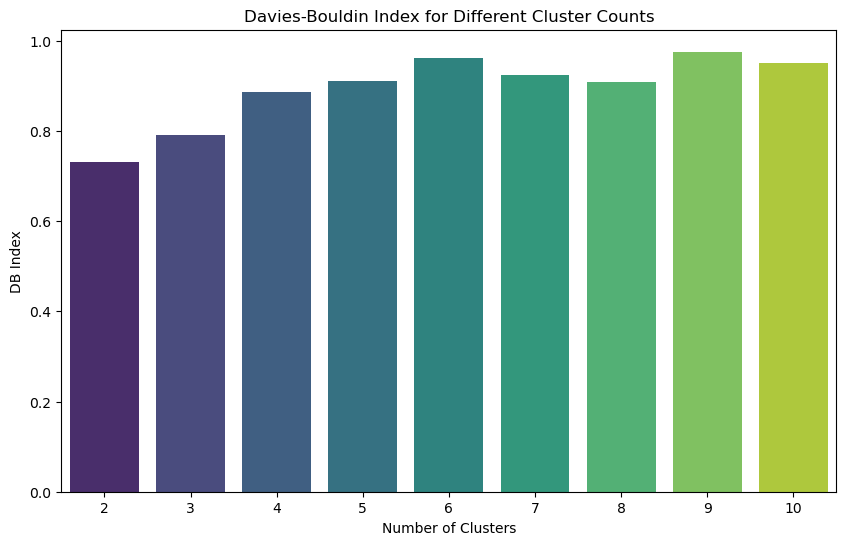

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x=[k for k, _ in db_index_scores], y=[score for _, score in db_index_scores], palette="viridis")
plt.title('Davies-Bouldin Index for Different Cluster Counts')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

# Visualize clusters in 2D space using PCA

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
customer_profiles['PCA1'] = pca_result[:, 0]
customer_profiles['PCA2'] = pca_result[:, 1]

# Graph plot 

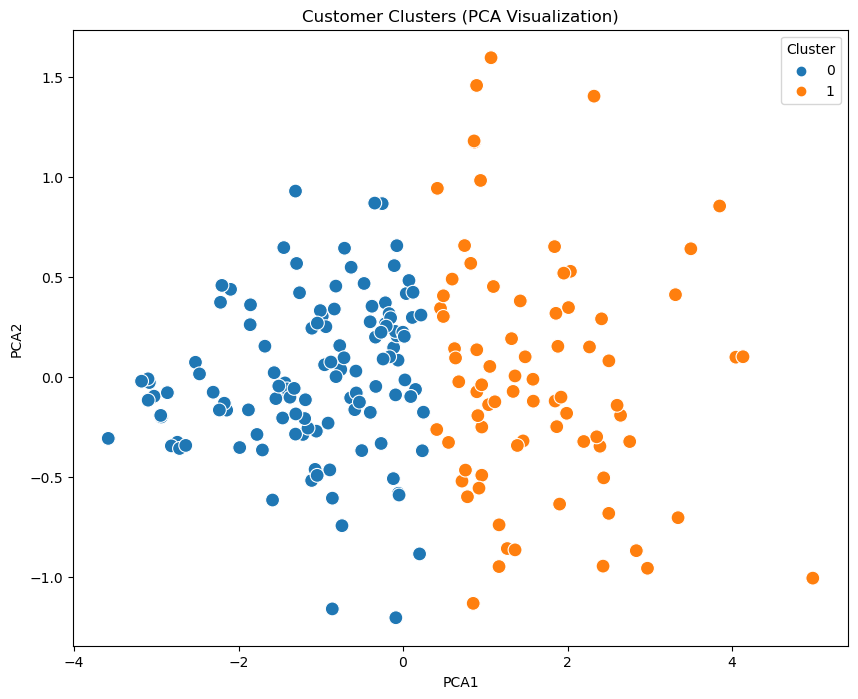

In [14]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=customer_profiles, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)
plt.title('Customer Clusters (PCA Visualization)')
plt.show()

In [15]:
#Print results
print(f'Optimal number of clusters: {best_k}')
print(f'Davies-Bouldin Index for optimal clusters: {best_db_index}')

Optimal number of clusters: 2
Davies-Bouldin Index for optimal clusters: 0.7316768187412903
